In [1]:
include("src\\ImportanceSampling.jl")
using Distributions
using ImportanceSampling
using Seaborn

In [63]:
srand(2^10);

## normal

In [64]:
function gen_w_normal(μ0::Vector{<:Real}, μ::Vector{<:Real}, Σ::Matrix{<:Real})
    invΣ = inv(Σ)
    dη = invΣ*(μ0-μ)
    C = exp(1/2*( dot(μ, invΣ*μ) - dot(μ0, invΣ*μ0) ))
    return (x::AbstractVector{<:Real}) -> C*exp(dot(x, dη))
end

gen_w_normal (generic function with 1 method)

In [65]:
function f!(r, x) 
    r[1] = x[1]
    r[2] = x[1]^2
    return r
end

f! (generic function with 1 method)

In [66]:
m0s = -3.5:0.5:3.5#linspace(-3.5, 3.5, nmeans)
nmeans = length(m0s)
q = Normal()
ws = [gen_w_normal([m0], zeros(1), eye(1)) for m0 in m0s]
;

In [67]:
ntrials = 50
niters = 10_000
;

In [68]:
ms_manual = zeros(ntrials, nmeans)
X = zeros(niters)
W = similar(X)

for i in 1:nmeans
    for tr in 1:ntrials
        rand!(q, X)
        W .= logpdf.(Normal(m0s[i]), X)
        W .-= logpdf.(q, X)
        map!(exp, W, W)
        ms_manual[tr, i] = mean(W.*X)
    end
end

In [69]:
iss = Matrix(ntrials, nmeans)

for i in 1:nmeans
    for tr in 1:ntrials
        iss[tr, i] = ImportanceSampler(f!, 2, q, w=ws[i])
        update!(iss[tr, i]; niters=niters, batchsize=1000)
    end
end

In [70]:
est_v_manual = vec(var(ms_manual, 1))
ms_avg_manual = vec(mean(ms_manual, 1))
;

In [71]:
ms = first.(mean.(iss))
vs = first.(var.(iss))
nes = ne.(iss)
neσs = neσ.(iss)

est_v = vec(var(ms, 1))
ms_avg = vec(mean(ms, 1))
vs_avg = vec(mean(vs, 1))
nes_avg = vec(mean(nes, 1))
neσs_avg = vec(mean(neσs, 1))
;

In [72]:
jitter = 1/16

0.08333333333333333

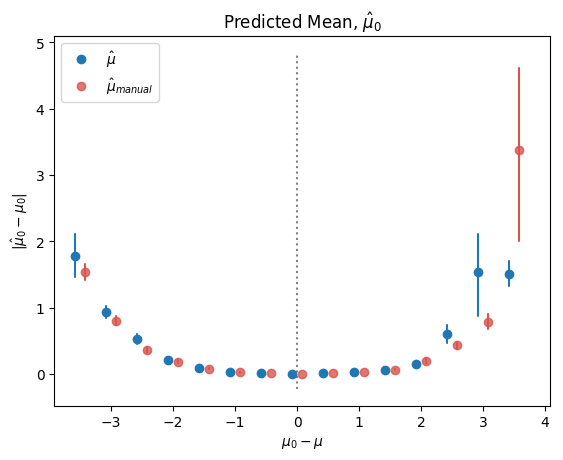

In [73]:
tsplot(abs.(ms.-m0s'), m0s-jitter, err_style="ci_bars", interpolate=false, 
    legend=true, condition=L"\hat \mu")
tsplot(abs.(ms_manual.-m0s'), m0s+jitter, err_style="ci_bars", interpolate=false, 
    legend=true, condition=L"\hat \mu_{manual}", 
    color=Seaborn.seaborn[:xkcd_rgb]["pale red"], alpha=0.8)
vlines(0, ylim()..., color="grey", linestyle="dotted")
title("Predicted Mean, " * L"\hat \mu_0")
xlabel(L"\mu_0 - \mu")
ylabel(L"|\hat \mu_0 - \mu_0|")
;

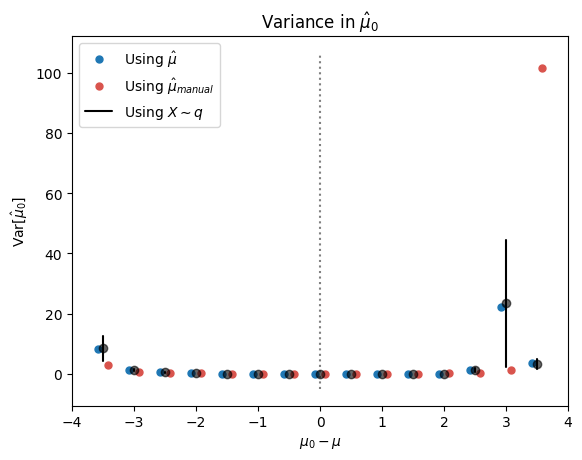

In [74]:
plot(m0s-jitter, est_v, ".", ms="10")
plot(m0s+jitter, est_v_manual, ".", ms="10", color=Seaborn.seaborn[:xkcd_rgb]["pale red"])
tsplot(vs, m0s, err_style="ci_bars", interpolate=false, alpha=0.6, color="k")
vlines(0, ylim()..., color="grey", linestyle="dotted")
title("Variance in " * L"\hat \mu_0")
xlabel(L"\mu_0 - \mu")
ylabel(L"\mathrm{Var}[\hat \mu_0]")
legend(["Using " * L"\hat \mu",
        "Using " * L"\hat \mu_{manual}",
        "Using " * L"X \sim q"])
;

In [75]:
m = zeros(1)
Σ = eye(1)
Λ = inv(1)
m0s_pred = linspace(first(m0s), last(m0s), 100)
nes_pred = niters * [exp(dot(m0, Λ*m0) - 1/2*dot(m, Λ*m)-1/2*dot(2*m0-m, Λ*(2*m0-m))) for m0 in m0s_pred];

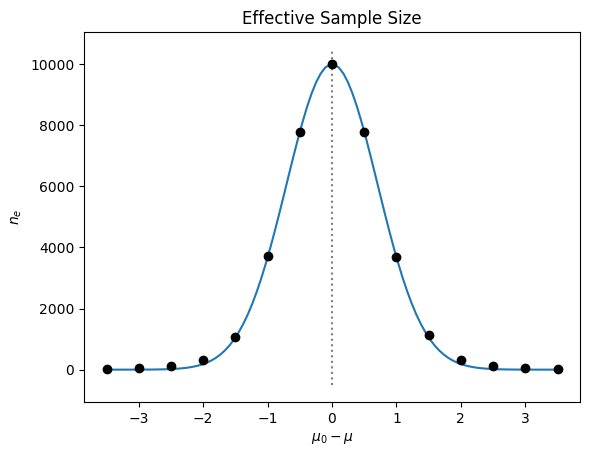

In [76]:
plot(m0s_pred, nes_pred) 
plot(m0s, nes_avg, "ko" )
vlines(0, ylim()..., color="grey", linestyle="dotted")
title("Effective Sample Size")
xlabel(L"\mu_0 - \mu")
ylabel(L"n_e")
;